# Airbnb Data Exploration

We chose the following cities for a comparison of Airbnb listing factors, and used information  for each city recorded on the dates shown:
* Amsterdam (March 7, 2019)
* Beijing (February 11, 2019)
* Las Vegas (February 13, 2019)
* Los Angeles (March 6, 2019)
* Madrid (March 8, 2019)
* New York (March 6, 2019)
* Paris (February 5, 2019)
* Sydney (March 7, 2019)

These cities were chosen subjectively, influenced by a desire to include well-known pleasure destinations worldwide, to have representation outside the US, and for availability of data. 

Airbnb data repositories for these cities, including listing csv files and geoJSON data, were downloaded from the website Inside Airbnb (http://insideairbnb.com/get-the-data.html ). This site scrapes Airbnb data from the Internet periodically and provides it to faciliate public discussion about the potentially negative effects Airbnb markets have on cities and neighborhoods (decreased residential housing, rental price inflation, unchecked gentrification). We have used the data to look mainly at lodging price and rating numbers for comparison between cities and neighborhoods, and also in comparison to hotel data. Qualitative  impact on communities has not been considered in this exploration.

Plots were used intermittently to help direct data exploration and data cleaning. For discussion of conclusions, see Airbnb_vs_Hotel.ipynb in main directory.

---

In [188]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import time
import os
import math
import json
import scipy.stats as stats

# Hide warning messages in notebook
import warnings
warnings.filterwarnings('ignore')

# gmaps and geojson
import geopy.distance
import gmaps
import gmaps.geojson_geometries

# Google developer API key
from config import gkey
gmaps.configure(api_key=gkey)

# List of Eight World Cities Chosen
cityL=["Amsterdam","Beijing","Las Vegas","Los Angeles","Madrid","New York","Paris","Sydney"]

# file to save geocodes for each city
geo_data_file = os.path.join("..","Resources","geocodes.csv")

In [189]:
# Get location and bounding box latitude and longitude for each city using Google geocode
# only run this once and save the coords to file that can be loaded in next cell
base_url = "https://maps.googleapis.com/maps/api/geocode/json?"

geobounds=[]
params={
    "key": gkey
}
for city in cityL:
    params["address"] = city
    response = requests.get(base_url, params=params)
    geo_data = response.json()
    cdict={"city":city}
    cdict["lat"] = geo_data["results"][0]["geometry"]["location"]["lat"]
    cdict["lng"] = geo_data["results"][0]["geometry"]["location"]["lng"]
    cdict["lat1"] = geo_data["results"][0]["geometry"]["bounds"]["northeast"]["lat"]
    cdict["lng1"] = geo_data["results"][0]["geometry"]["bounds"]["northeast"]["lng"]
    cdict["lat2"] = geo_data["results"][0]["geometry"]["bounds"]["southwest"]["lat"]
    cdict["lng2"] = geo_data["results"][0]["geometry"]["bounds"]["southwest"]["lng"]
    geobounds.append(cdict)

geodf = pd.DataFrame(geobounds)

# file to save geocodes for each city
geo_data_file = os.path.join("..","Resources","geocodes.csv")
# save geography coords
geodf.to_csv(geo_data_file, index = False)

geodf

,city,lat,lat1,lat2,lng,lng1,lng2
0,Amsterdam,52.367984,52.431157,52.278139,4.903561,5.068390,4.728856
1,Beijing,39.904200,41.060816,39.442758,116.407396,117.514625,115.423411
2,Las Vegas,36.169941,36.380623,36.129623,-115.139830,-115.062072,-115.414625
3,Los Angeles,34.052234,34.337306,33.703652,-118.243685,-118.155289,-118.668176
4,Madrid,40.416775,40.563845,40.312064,-3.703790,-3.524911,-3.834162
5,New York,40.712775,40.917577,40.477399,-74.005973,-73.700272,-74.259090
6,Paris,48.856614,48.902145,48.815573,2.352222,2.469921,2.224199
7,Sydney,-33.868820,-33.578141,-34.118347,151.209295,151.343021,150.520929


In [190]:
# retrieve geography coords without re-running cell above
geodf = pd.read_csv(geo_data_file, index_col = "city")

In [192]:
# retrieve Airbnb info saved in folders with city names, merge into one dataframe

# function for returning distance to point center for row with latitude and longitude in df
def get_distance (row, center):
    start = (row['latitude'], row['longitude'])
    return geopy.distance.distance(start, center).km

dfexists = False

for city in cityL:
    path = os.path.join(city,"listings 2.csv")
    #print(path)
    citydf = pd.read_csv(path)
    citydf["key"]=city
    # make sure this only includes locations within city bounding box
    coords = geodf.loc[city]
    citydf = citydf.loc[(citydf["latitude"]<=coords["lat1"]) & (citydf["latitude"]>=coords["lat2"])
                 &(citydf["longitude"]<=coords["lng1"]) & (citydf["longitude"]>=coords["lng2"])]
    # add a new column, distance to center
    center = (coords["lat"],coords["lng"])
    # give each location a distance to center of city
    citydf["center_distance"] = citydf.apply (lambda row: get_distance(row, center),axis=1)
    if dfexists:
        allcitydf = pd.concat([allcitydf, citydf], ignore_index=True)
    else:
        allcitydf = citydf
        dfexists = True


allcitydf.head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,key,center_distance
0,2818,https://www.airbnb.com/rooms/2818,20190307044014,2019-03-07,Quiet Garden View Room & Super Fast WiFi,Quiet Garden View Room & Super Fast WiFi,I'm renting a bedroom (room overlooking the ga...,Quiet Garden View Room & Super Fast WiFi I'm r...,none,"Indische Buurt (""Indies Neighborhood"") is a ne...",...,strict_14_with_grace_period,f,f,1,0,1,0,2.07,Amsterdam,2.590703
1,20168,https://www.airbnb.com/rooms/20168,20190307044014,2019-03-07,100%Centre-Studio 1 Private Floor/Bathroom,"Cozy studio on your own private floor, 100% in...",For those who like all facets of city life. In...,"Cozy studio on your own private floor, 100% in...",none,Located just in between famous central canals....,...,strict_14_with_grace_period,f,f,2,1,1,0,2.29,Amsterdam,0.754776
2,25428,https://www.airbnb.com/rooms/25428,20190307044014,2019-03-07,Lovely apt in City Centre (Jordaan),NaN,"This nicely furnished, newly renovated apt is...","This nicely furnished, newly renovated apt is...",none,NaN,...,strict_14_with_grace_period,f,f,2,2,0,0,0.15,Amsterdam,1.469958
3,27886,https://www.airbnb.com/rooms/27886,20190307044014,2019-03-07,"Romantic, stylish B&B houseboat in canal district",Stylish and romantic houseboat on fantastic hi...,For a romantic couple: A beautifully restored ...,Stylish and romantic houseboat on fantastic hi...,none,"Central, quiet, safe, clean and beautiful.",...,strict_14_with_grace_period,f,f,1,0,1,0,2.07,Amsterdam,2.227640
4,28658,https://www.airbnb.com/rooms/28658,20190307044014,2019-03-07,Cosy guest room near city centre -1,2 beds guest room in Amsterdam West near Erasm...,Cosy small but comfortable guest room with twi...,2 beds guest room in Amsterdam West near Erasm...,none,"The listing is located in Amsterdam west, betw...",...,moderate,t,t,2,0,2,0,4.14,Amsterdam,3.256001


In [273]:
allcitydf["id"].count()

245864

In [198]:
# get approx city bounding box size for metro size area comparison
# compute relative density of airbnb listings per city (listings per squ km)

sizeL = []
area_file = os.path.join("..","Resources", "city_area.csv")
# areas of cities looked up on the Internet, saved as .csv
areadf = pd.read_csv(area_file).set_index("city")

citycounts = allcitydf.groupby("key")['id'].count()

for city in cityL:
    cdict={"city":city}
    coords = geodf.loc[city]
    width = geopy.distance.distance((coords['lat1'],coords['lng1']),(coords['lat2'],coords['lng1'])).km
    height = geopy.distance.distance((coords['lat1'],coords['lng1']),(coords['lat1'],coords['lng2'])).km
    cdict["width (km)"]=width
    cdict["height (km)"]=height
    cdict["listing_count"] = citycounts[city]
    # bounding box area much larger than actual city area as looked up with Google
    # cdict["area"] = width * height
    cdict["area (km2)"]= areadf.loc[city,"area (km2)"]
    cdict["list/sq_km"] = cdict["listing_count"]/cdict["area (km2)"]
    sizeL.append(cdict)

    
sizedf = pd.DataFrame(sizeL).set_index("city")
sizefile = os.path.join("..","Resources","sizedensity.csv")
# save size/density
sizedf.to_csv(sizefile, index = True)
sizedf

,area (km2),height (km),list/sq_km,listing_count,width (km)
city,,,,,
Amsterdam,219.3,23.093845,88.718650,19456,17.026982
Beijing,16810.0,175.778629,1.541999,25921,179.668299
Las Vegas,352.0,31.634010,5.502841,1937,27.851909
Los Angeles,1300.0,47.194780,28.640769,37233,70.286673
Madrid,604.3,26.189575,29.210657,17652,27.958511
New York,783.8,47.074680,63.470273,49748,48.880916
Paris,105.4,18.015094,550.796964,58054,9.627402
Sydney,12370.0,76.322001,2.902910,35909,59.919472


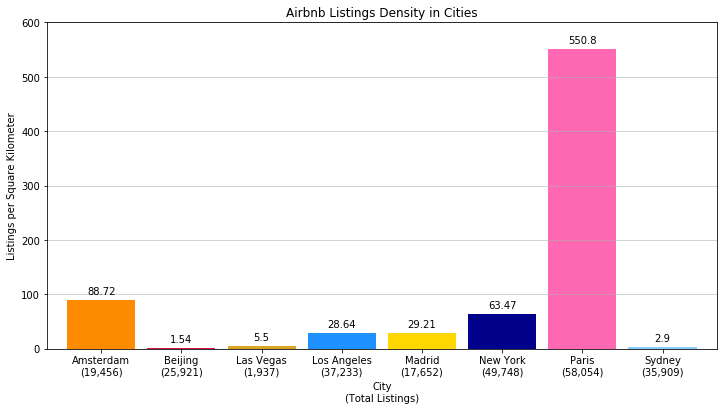

In [206]:
# bar plot approx density of listings for each city
colors = ["darkorange", "crimson", "goldenrod", "dodgerblue", "gold", "darkblue", "hotpink","lightskyblue"]

# Use functions to label the percentages of changes
def labelbar(bar, label, **kwargs):
    height = bar.get_height()
    if not 'pos' in kwargs:
        pos = "top"
    else:
        pos = kwargs["pos"]
    if not 'ybot' in kwargs:
        ybot = 0
    else:
        ybot = kwargs["ybot"]
    offset = 16*abs(height)/height
    if (pos == "top"):
        placement = height+offset -ybot
    else:
        placement = offset
    plt.text(bar.get_x() + bar.get_width() / 2, placement, label,
            ha='center', va='center', color="black")

plt.figure( figsize=(12,6))
myplot = sizedf["list/sq_km"].plot(kind='bar', width=.85, color = colors)
cities = list(sizedf.index.values)
totalcounts = sizedf['listing_count'].tolist()
xticklabels = [city+os.linesep+'('+"{:,}".format(num)+')' for city, num in zip(cities, totalcounts)]
plt.xticks(np.arange(8), xticklabels, rotation=0)
plt.xlabel("City"+os.linesep+"(Total Listings)")
plt.grid(axis='y', alpha=.7)
plt.ylabel("Listings per Square Kilometer")
plt.ylim(0,600)
plt.title ("Airbnb Listings Density in Cities")
# Make some labels.
labels = [str(round(s,2)) for s in  sizedf['list/sq_km']]

# Call functions to implement the function calls
for bar, label in zip(myplot.patches, labels):
    labelbar(bar, label)

# Save the Figure
imagepath = os.path.join("saveImages","AirbnbListingDensity.png")
plt.savefig(imagepath)

plt.show()

In [6]:
# list cols in db
list(allcitydf)

['id',
 'listing_url',
 'scrape_id',
 'last_scraped',
 'name',
 'summary',
 'space',
 'description',
 'experiences_offered',
 'neighborhood_overview',
 'notes',
 'transit',
 'access',
 'interaction',
 'house_rules',
 'thumbnail_url',
 'medium_url',
 'picture_url',
 'xl_picture_url',
 'host_id',
 'host_url',
 'host_name',
 'host_since',
 'host_location',
 'host_about',
 'host_response_time',
 'host_response_rate',
 'host_acceptance_rate',
 'host_is_superhost',
 'host_thumbnail_url',
 'host_picture_url',
 'host_neighbourhood',
 'host_listings_count',
 'host_total_listings_count',
 'host_verifications',
 'host_has_profile_pic',
 'host_identity_verified',
 'street',
 'neighbourhood',
 'neighbourhood_cleansed',
 'neighbourhood_group_cleansed',
 'city',
 'state',
 'zipcode',
 'market',
 'smart_location',
 'country_code',
 'country',
 'latitude',
 'longitude',
 'is_location_exact',
 'property_type',
 'room_type',
 'accommodates',
 'bathrooms',
 'bedrooms',
 'beds',
 'bed_type',
 'amenities',


In [199]:
# allcitydf.dtypes
# convert price to float
if allcitydf["price"].dtype == 'object':
    allcitydf["price"] = allcitydf["price"].str.replace('$', '')
    allcitydf["price"] = allcitydf["price"].str.replace(',', '')
    allcitydf["price"] = allcitydf["price"].astype(float)

allcitydf["price"].describe()

# drop listings with price = 0
allcitydf = allcitydf.loc[allcitydf['price']!=0]
allcitydf["price"].describe()

count    245864.000000
mean        200.145519
std         597.544722
min           6.000000
25%          69.000000
50%         109.000000
75%         199.000000
max       68980.000000
Name: price, dtype: float64

In [200]:
# dataframe with useful categories
catsdf = allcitydf[['id','latitude','longitude','neighbourhood_cleansed','neighbourhood_group_cleansed','room_type','accommodates','price','number_of_reviews','review_scores_rating','key','center_distance']]

catsdf.count()

# drop rows without a 'review_score_rating' because rating is target of interest
catsdf = catsdf.dropna(subset=['review_scores_rating'])

# save general airbnb data, all cities, all listings, cleaned but unfiltered for private double occupancy
allcleanfile = os.path.join("saveData", "allcleancats.csv")
catsdf.to_csv(allcleanfile)
catsdf.count()

id                              186361
latitude                        186361
longitude                       186361
neighbourhood_cleansed          186361
neighbourhood_group_cleansed     52372
room_type                       186361
accommodates                    186361
price                           186361
number_of_reviews               186361
review_scores_rating            186361
key                             186361
center_distance                 186361
dtype: int64

In [201]:
# filter type of accommodation to exclude shared rooms
filterdf = catsdf.loc[catsdf['room_type']!='Shared room']

# check for any trend with number of people accommodated
# get average ratings/price for private rooms according to amount accommodated
fmeandf = filterdf.groupby(["key","accommodates"]).mean()
fmeandf = fmeandf.reset_index()

# check price and rating trends according to accommodates number
# reformatting
guestL = fmeandf["accommodates"].unique()
reformatdf = pd.DataFrame({"accommodates":guestL})

for city in cityL:
    addf= fmeandf.loc[fmeandf["key"]==city][["accommodates",'price','review_scores_rating']].rename(columns = {'review_scores_rating':city+' rating', 'price':city+' price'})
    reformatdf = pd.merge(reformatdf,addf, on="accommodates")

reformatdf = reformatdf.set_index('accommodates')
reformatdf

,Amsterdam price,Amsterdam rating,Beijing price,Beijing rating,Las Vegas price,Las Vegas rating,Los Angeles price,Los Angeles rating,Madrid price,Madrid rating,New York price,New York rating,Paris price,Paris rating,Sydney price,Sydney rating
accommodates,,,,,,,,,,,,,,,,
1,75.211221,94.079208,242.324440,95.677695,42.112500,95.050000,76.754745,95.031968,29.167979,93.643701,74.113857,93.834731,66.364910,92.589686,65.069021,93.284644
2,118.276573,95.157141,343.631634,94.917943,72.100719,95.489209,96.618328,95.039733,55.246704,92.673296,109.047070,94.055740,77.281388,92.974650,112.729176,93.509404
3,137.728190,94.504686,386.221538,95.227692,57.675676,95.148649,120.838086,94.404458,108.769175,91.820307,143.313376,93.470510,95.198784,92.311346,140.851176,92.169412
4,194.634292,94.666152,574.567871,94.513855,96.990610,92.755869,154.947036,94.547992,95.273497,92.396721,173.857288,94.042492,117.971416,92.600885,204.965422,93.253902
5,215.820423,95.274648,618.558600,93.920852,107.510204,94.571429,189.924460,94.066547,114.278431,92.149020,217.486551,93.173939,162.178687,92.995694,239.489922,92.563566
6,292.793919,94.655405,792.063126,94.492986,153.899598,93.305221,262.925873,94.148967,134.003526,92.078279,253.548738,93.516576,211.446755,92.948003,316.956809,93.294403
7,329.315789,94.815789,825.464455,94.317536,160.187500,94.843750,282.200397,93.773810,139.950226,92.090498,300.718519,92.995062,259.021622,93.197297,397.300000,93.621739
8,310.584615,92.492308,1174.449827,95.069204,234.777778,94.407407,407.009877,94.340741,171.376147,92.256881,327.924242,93.579125,359.997727,93.065909,537.129780,94.619930
9,335.800000,92.200000,1228.136364,94.939394,154.681818,94.181818,384.841176,94.370588,149.305556,90.694444,372.234783,92.330435,347.234568,93.740741,525.795031,93.341615


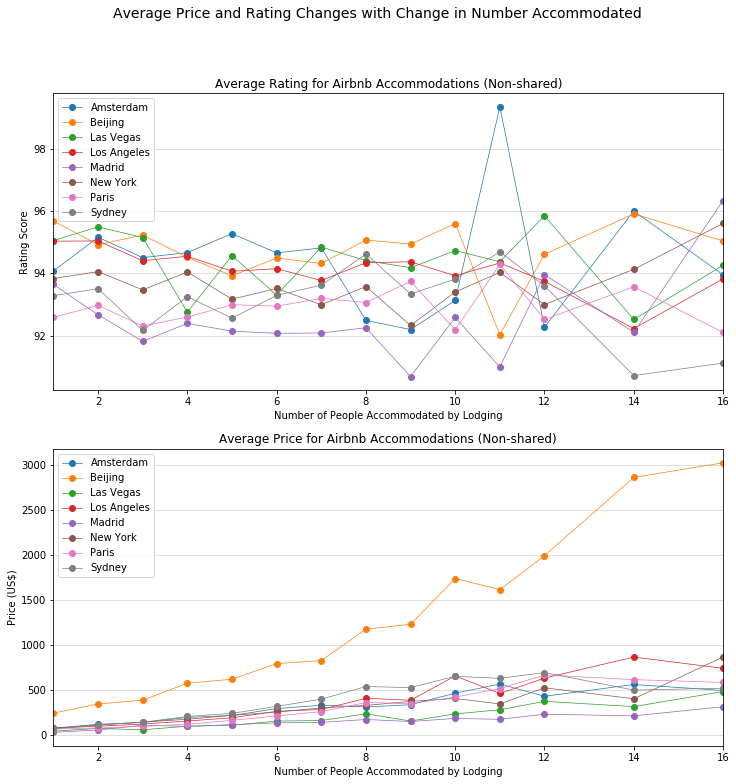

In [38]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize = (12,12))

for city in cityL:
    reformatdf[city+' rating'].plot(ax=ax1, marker = "o", linewidth = .7, label=city)
ax1.yaxis.set_label_text("Rating Score")
ax1.xaxis.set_label_text("Number of People Accommodated by Lodging")
ax1.set_title("Average Rating for Airbnb Accommodations (Non-shared)")
ax1.grid(axis='y',alpha = .5)
ax1.legend()

for city in cityL:
    reformatdf[city+' price'].plot(ax=ax2, marker = "o", linewidth = .7, label=city)
ax2.set_title("Average Price for Airbnb Accommodations (Non-shared)")
ax2.xaxis.set_label_text("Number of People Accommodated by Lodging")
ax2.yaxis.set_label_text("Price (US$)")
ax2.grid(axis='y',alpha = .5)
ax2.legend()


fig.suptitle("Average Price and Rating Changes with Change in Number Accommodated", fontsize=14)
#plt.subplots_adjust(hspace=.8)
fig.show()

# Save the Figure
imagepath = os.path.join("saveImages","NumberAccommodatedChanges.png")
plt.savefig(imagepath)

In [274]:
# filter for only double occupancy to compare to hotel
doubledf = filterdf.loc[filterdf["accommodates"]==2]

# save to .csv for hotel comparison
doubleAllCity_file = os.path.join("saveData","airbnb_double.csv")
doubledf.to_csv(doubleAllCity_file)

meandf = doubledf.groupby(["key"])[['price','review_scores_rating']].mean()

#save mean price/rating file
meanAirbnb_file = os.path.join("saveData","meanAirbnb.csv")
meandf.to_csv(meanAirbnb_file)
doubledf.count()


id                              81579
latitude                        81579
longitude                       81579
neighbourhood_cleansed          81579
neighbourhood_group_cleansed    21662
room_type                       81579
accommodates                    81579
price                           81579
number_of_reviews               81579
review_scores_rating            81579
key                             81579
center_distance                 81579
dtype: int64

In [255]:
mediandf = doubledf.groupby(["key"])[['price','review_scores_rating']].median()
mediandf

,price,review_scores_rating
key,,
Amsterdam,110.0,97.0
Beijing,297.0,99.0
Las Vegas,48.0,98.0
Los Angeles,85.0,97.0
Madrid,44.0,95.0
New York,90.0,96.0
Paris,65.0,95.0
Sydney,100.0,97.0


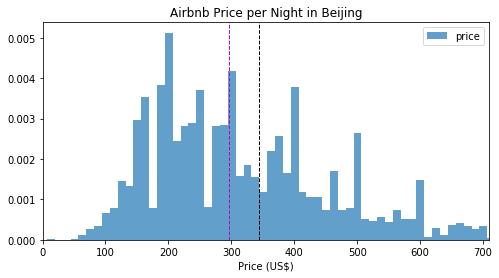

In [42]:

# look at median vs mean because there are some very expensive outliers
mcity = "Beijing"
mcitydf = doubledf.loc[doubledf['key']==mcity]

# Histogram Plot of Data, look at mean vs median price for Beijing
plt.figure(figsize=(8,4))
plt.subplot(1, 1, 1)
plt.hist(mcitydf['price'], 800, density=True, alpha=0.7, label="price")
plt.axvline(mcitydf['price'].mean(), color='k', linestyle='dashed', linewidth=1)
plt.axvline(mcitydf['price'].median(), color='m', linestyle='dashed', linewidth=1)
x25 = np.percentile(mcitydf['price'], 25)
x75 = np.percentile(mcitydf['price'], 75)
xmax = x75 + 1.5 * (x75 - x25)
plt.xlim(0,xmax)
plt.xlabel('Price (US$)')
plt.title(f'Airbnb Price per Night in {mcity}')
plt.legend()
plt.show()

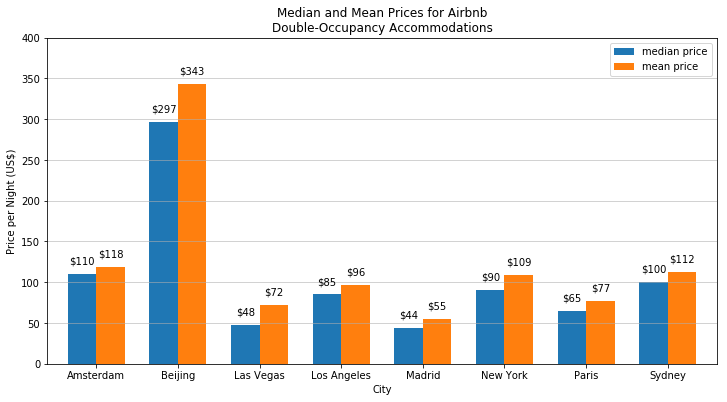

In [209]:
# bar plot median-mean price comparison for each city
medmeandf = mediandf
medmeandf['mean price'] =  meandf['price']
medmeandf = medmeandf.rename(columns={'price':'median price'})


myplot = medmeandf[["median price",'mean price']].plot(kind='bar', figsize = (12,6), width=.7)
plt.xlabel("City")
plt.ylabel("Price per Night (US$)")
plt.xticks(rotation=0)
plt.title (f"Median and Mean Prices for Airbnb{os.linesep}Double-Occupancy Accommodations")
plt.grid(axis='y', alpha=.7)
plt.ylim(0,400)

# Make some labels
vals = [*medmeandf['median price'], *medmeandf['mean price']]
labels = ["$"+str(int(val))  for val in vals]

# Call functions to implement the function calls
for bar, label in zip(myplot.patches, labels):
    labelbar(bar, label)

# Save the Figure
imagepath = os.path.join("saveImages","MedianAndMeanAirbnb.png")
plt.savefig(imagepath)

plt.show()

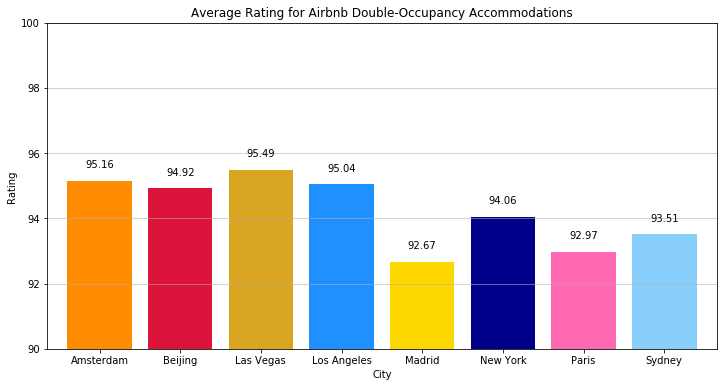

In [210]:
# bar plot RATING comparison for double-occupancy accommodations in each city

rplot = meandf["review_scores_rating"].plot(kind='bar', color=colors, figsize = (12,6), width=.8)
plt.xlabel("City")
plt.ylabel("Rating")
plt.xticks(rotation=0)
plt.title ("Average Rating for Airbnb Double-Occupancy Accommodations")
plt.grid(axis='y', alpha=.7)
plt.ylim(90,100)

# Make some labels
labels = [str(round(val,2))  for val in meandf["review_scores_rating"]]

# Call functions to implement the function calls
for bar, label in zip(rplot.patches, labels):
    labelbar(bar, label, ybot = 15.5)

# Save the Figure
imagepath = os.path.join("saveImages","AverageRatingAirbnb.png")
plt.savefig(imagepath)

plt.show()

In [211]:
# Plot Heatmap of City Listings with Intensity by Price, try New York
city ="New York"
citydf=doubledf.loc[doubledf["key"]==city]
locations = citydf[["latitude", "longitude"]]
pricing = citydf["price"]

coords = geodf.loc[city]
cen = (coords["lat"],coords["lng"])
fig = gmaps.figure(map_type='HYBRID', center=cen, zoom_level=11)
heatmap_layer = gmaps.heatmap_layer(locations, weights=pricing,
                                    max_intensity=400, point_radius=1.5)
fig.add_layer(heatmap_layer)
fig

Figure(layout=FigureLayout(height='420px'))

In [212]:
# Heatmap with intensity by rating on city, try New York
city ="New York"
citydf=doubledf.loc[doubledf["key"]==city]
locations = citydf[["latitude", "longitude"]]
rating = citydf["review_scores_rating"]

coords = geodf.loc[city]
cen = (coords["lat"],coords["lng"])
fig = gmaps.figure(map_type='HYBRID', center=cen, zoom_level=11)
heatmap_layer = gmaps.heatmap_layer(locations, weights=rating,
                                    max_intensity=400, point_radius=2.0)
fig.add_layer(heatmap_layer)
fig

Figure(layout=FigureLayout(height='420px'))

In [126]:
# Chloropleth of Neighborhoods, color according to Average Price double occupancy Airbnb accommodations
# remove outliers and add symbol layer for info box showing neighborhood name and mean price

city = "Madrid"
cgeopath=os.path.join(city,"neighbourhoods.geojson")

with open(cgeopath,encoding='utf-8', errors='ignore') as json_data:
     neigh = json.load(json_data, strict=False)

def remove_outlier(df_in, col_name):
    q1 = df_in[col_name].quantile(0.25)
    q3 = df_in[col_name].quantile(0.75)
    iqr = q3-q1 #Interquartile range
    fence_low  = q1-1.5*iqr
    fence_high = q3+1.5*iqr
    df_out = df_in.loc[(df_in[col_name] > fence_low) & (df_in[col_name] < fence_high)]
    return df_out

citydf = doubledf.loc[doubledf["key"]== city]
citydf = remove_outlier(citydf, 'price')
groupcitydf = citydf.groupby("neighbourhood_cleansed")[['price','review_scores_rating']].mean()
pmax = groupcitydf['price'].max()
pmin = groupcitydf['price'].min()

features= neigh['features']
colors= []
centroids=[]
labels = []

for hood in features:
    nname = hood["properties"]["neighbourhood"]
    coords = hood["geometry"]["coordinates"][0][0]
    
    #get centroid for symbol layer with info box
    centroid = np.asarray(coords).mean(axis=0)
    loc=(centroid[1], centroid[0])
    centroids.append(loc)
    
    try:
        p = groupcitydf.loc[nname]['price']
        c = int(255 * (p-pmin)/(pmax-pmin))
        color = (c,255-c,255-c, 1)
    except (KeyError, ValueError) as e:
        color = (255, 255, 255, 0.0)
    colors.append(color)
    labels.append(nname+": $"+str(int(p)))

#colors
symbol_layer = gmaps.symbol_layer(centroids, info_box_content=labels, fill_color=(0,0,0,.7), stroke_color=colors, stroke_opacity=.7, scale=2)

coords = geodf.loc[city]
cen = (coords["lat"],coords["lng"])
fig = gmaps.figure() #center=cen, zoom_level=10)

nlay = gmaps.geojson_layer(neigh,fill_color=colors,stroke_color='white', fill_opacity=.8)
fig.add_layer(nlay)
fig.add_layer(symbol_layer)
fig


Figure(layout=FigureLayout(height='420px'))

In [18]:
newyorkdf.head()

,id,latitude,longitude,neighbourhood_cleansed,neighbourhood_group_cleansed,room_type,accommodates,price,number_of_reviews,review_scores_rating,key,center_distance
102199,2539,40.64749,-73.97237,Kensington,Brooklyn,Private room,2,149.0,9,98.0,New York,7.786496
102201,3330,40.70856,-73.94236,Williamsburg,Brooklyn,Private room,2,70.0,39,97.0,New York,5.395753
102206,5121,40.68688,-73.95596,Bedford-Stuyvesant,Brooklyn,Private room,2,60.0,49,90.0,New York,5.112301
102207,5178,40.76489,-73.98493,Hell's Kitchen,Manhattan,Private room,2,79.0,415,84.0,New York,6.054071
102213,5441,40.76076,-73.98867,Hell's Kitchen,Manhattan,Private room,2,85.0,173,97.0,New York,5.525449


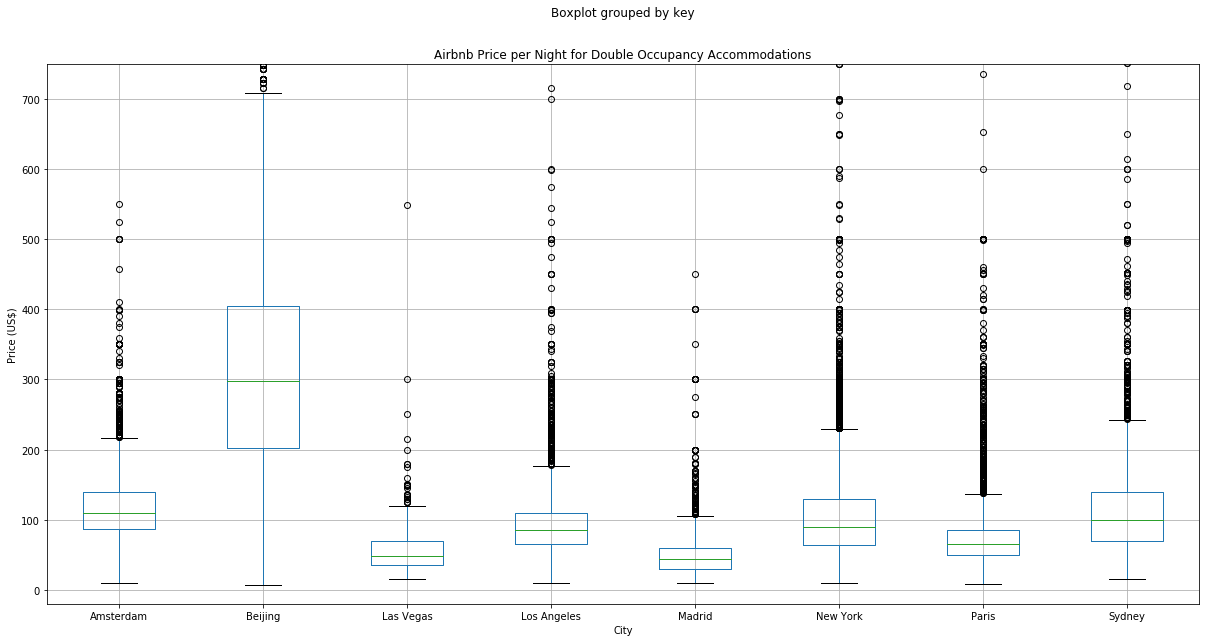

In [144]:
# Show box plot with price ranges for nightly double-occupancy lodging cost in each city
mybox = doubledf.boxplot("price", by="key", figsize=(20, 10))
# adjust ylim because of hugely, expensive outliers
plt.ylim(-20,750)
plt.xlabel("City")
plt.ylabel("Price (US$)")
plt.title("Airbnb Price per Night for Double Occupancy Accommodations")

# Save the Figure
imagepath = os.path.join("saveImages","AirbnbPriceBoxplot.png")
plt.savefig(imagepath)

plt.show()


In [148]:
# Null hypothesis: Prices are about the same in each city, run ANOVA
# Extract individual groups
g1 = doubledf[doubledf["key"] == "Amsterdam"]["price"]
g2 = doubledf[doubledf["key"] == "Beijing"]["price"]
g3 = doubledf[doubledf["key"] == "Las Vegas"]["price"]
g4 = doubledf[doubledf["key"] == "Los Angeles"]["price"]
g5 = doubledf[doubledf["key"] == "Madrid"]["price"]
g6 = doubledf[doubledf["key"] == "New York"]["price"]
g7 = doubledf[doubledf["key"] == "Paris"]["price"]
g8 = doubledf[doubledf["key"] == "Sydney"]["price"]

# Perform the ANOVA
stats.f_oneway(g1, g2, g3, g4, g5, g6, g7, g8)

F_onewayResult(statistic=1975.0873644553315, pvalue=0.0)

In [38]:
# As seen by 0 pvalue, accommodation prices vary significantly between the 8 cities.

doubledf.head()

,id,latitude,longitude,neighbourhood_cleansed,neighbourhood_group_cleansed,room_type,accommodates,price,number_of_reviews,review_scores_rating,key,center_distance
0,2818,52.36575,4.94142,Oostelijk Havengebied - Indische Buurt,NaN,Private room,2,59.0,250,97.0,Amsterdam,2.590703
1,20168,52.36509,4.89354,Centrum-Oost,NaN,Entire home/apt,2,80.0,251,87.0,Amsterdam,0.754776
3,27886,52.38673,4.89208,Centrum-West,NaN,Private room,2,150.0,180,99.0,Amsterdam,2.227640
4,28658,52.37534,4.85729,Bos en Lommer,NaN,Private room,2,65.0,444,93.0,Amsterdam,3.256001
5,28871,52.36719,4.89092,Centrum-West,NaN,Private room,2,75.0,240,97.0,Amsterdam,0.865582


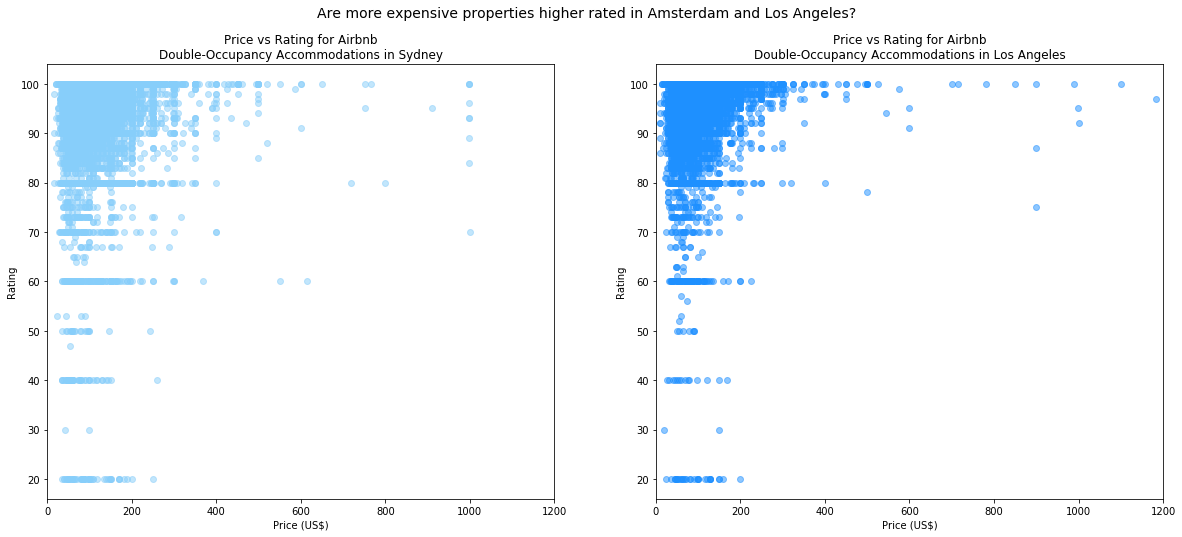

In [272]:
# Are there higher ratings for more expensive properties?

mcity = "Sydney"
altcity = "Los Angeles"

mcitydf = doubledf.loc[doubledf['key']==mcity]
altcitydf = doubledf.loc[doubledf['key']==altcity]

colordict = {"Amsterdam":"darkorange", "Beijing":"crimson", "Las Vegas":"goldenrod", "Los Angeles":"dodgerblue", 
             "Madrid":"gold", "New York":"darkblue", "Paris":"hotpink","Sydney":"lightskyblue"}
mc = colordict[mcity]
ac = colordict[altcity]

# plot rating vs price for each city
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20,8))
ax1.scatter(mcitydf["price"], mcitydf["review_scores_rating"], c=mc, alpha=.5)
ax1.set_title(f"Price vs Rating for Airbnb{os.linesep}Double-Occupancy Accommodations in {mcity}")
ax1.yaxis.set_label_text("Rating")
ax1.xaxis.set_label_text('Price (US$)')
ax1.set_xlim(0,1200)

ax2.scatter(altcitydf["price"], altcitydf["review_scores_rating"], c=ac, alpha=.5)
ax2.set_title(f"Price vs Rating for Airbnb{os.linesep}Double-Occupancy Accommodations in {altcity}")
ax2.yaxis.set_label_text('Rating')
ax2.xaxis.set_label_text('Price (US$)')
ax2.set_xlim(0,1200)

fig.suptitle(f"Are more expensive properties higher rated in {city} and {altcity}?", fontsize=14)

# Save the Figure
imagepath = os.path.join("saveImages","AirbnbRatingPriceScatter.png")
plt.savefig(imagepath)

fig.show()

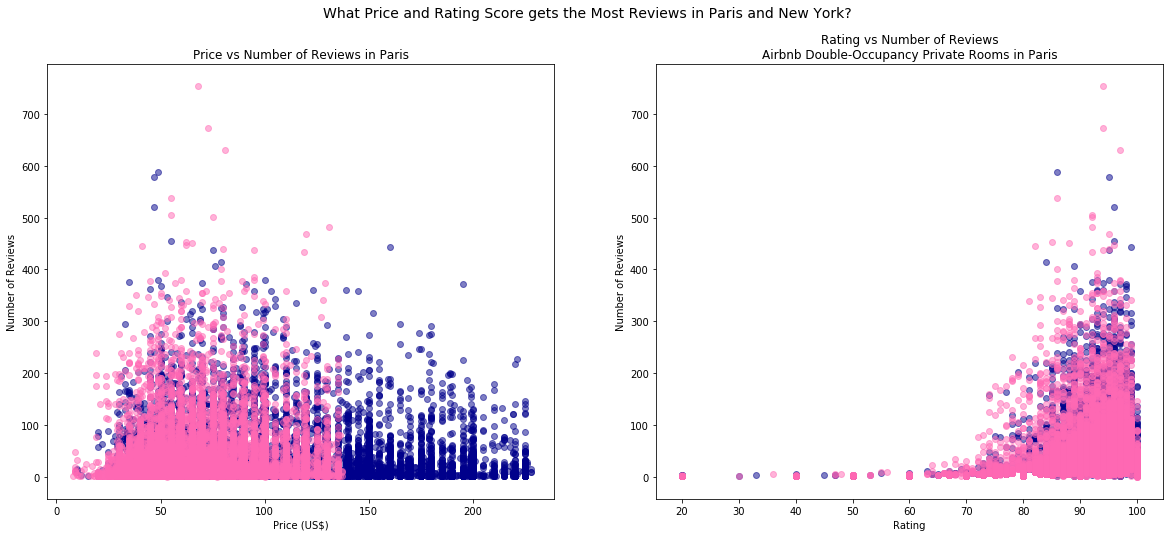

In [213]:
# What do most people choose -- what price/rating get the most reviews?
mcity = "Paris"
mcitydf = doubledf.loc[doubledf['key']==mcity]


altcity = "New York"
altcitydf  = doubledf.loc[doubledf['key']==altcity]

def remove_outlier(df_in, col_name):
    q1 = df_in[col_name].quantile(0.25)
    q3 = df_in[col_name].quantile(0.75)
    iqr = q3-q1 #Interquartile range
    fence_low  = q1-1.5*iqr
    fence_high = q3+1.5*iqr
    df_out = df_in.loc[(df_in[col_name] > fence_low) & (df_in[col_name] < fence_high)]
    return df_out

mcitydf = remove_outlier(mcitydf, "price")
colordict = {"Amsterdam":"darkorange", "Beijing":"crimson", "Las Vegas":"goldenrod", "Los Angeles":"dodgerblue", "Madrid":"gold", "New York":"darkblue", "Paris":"hotpink","Sydney":"lightskyblue"}
color= colordict[mcity]

altcitydf = remove_outlier(altcitydf, "price")
acolor = colordict[altcity]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20,8))
ax1.scatter(altcitydf["price"],altcitydf["number_of_reviews"], c=acolor, alpha=.5)
ax1.scatter(mcitydf["price"],mcitydf["number_of_reviews"], c=color, alpha=.5)
ax1.set_title(f"Price vs Number of Reviews in {mcity}")
ax1.xaxis.set_label_text('Price (US$)')
ax1.yaxis.set_label_text("Number of Reviews")
#ax1.xlim(0,200)

ax2.scatter(altcitydf["review_scores_rating"],altcitydf["number_of_reviews"], c=acolor, alpha=.5)
ax2.scatter(mcitydf["review_scores_rating"],mcitydf["number_of_reviews"], c=color, alpha=.5)
ax2.set_title(f"Rating vs Number of Reviews{os.linesep}Airbnb Double-Occupancy Private Rooms in {mcity}")
ax2.xaxis.set_label_text('Rating')
ax2.yaxis.set_label_text("Number of Reviews")

fig.suptitle(f"What Price and Rating Score gets the Most Reviews in {mcity} and {altcity}?", fontsize=14)

# Save the Figure
imagepath = os.path.join("saveImages","NumberofRatings.png")
plt.savefig(imagepath)

fig.show()

In [214]:
meandf

,price,review_scores_rating
key,,
Amsterdam,118.276573,95.157141
Beijing,343.631634,94.917943
Las Vegas,72.100719,95.489209
Los Angeles,96.618328,95.039733
Madrid,55.246704,92.673296
New York,109.047070,94.055740
Paris,77.281388,92.974650
Sydney,112.729176,93.509404


In [230]:
# look at description field of for airbnb rentals for possible influence on other factors

# function that returns city subset df with chosen fields + description word count + color for city
def getDescDF (city):
    vcitydf = allcitydf.loc[allcitydf["key"]==city][['description','price','review_scores_rating','number_of_reviews']]
    vcitydf = vcitydf.dropna(subset=["description",'review_scores_rating','number_of_reviews'])
    dseries = vcitydf['description']
    wcount = [len(desc.split(' ')) for desc in dseries]
    vcitydf['desc_word_count'] = wcount
    color = colordict[city]
    return vcitydf, color

# get df for Amsterdam
city="Amsterdam"
vcitydf, c = getDescDF(city)
vcitydf.head()

,description,price,review_scores_rating,number_of_reviews,desc_word_count
0,Quiet Garden View Room & Super Fast WiFi I'm r...,59.0,97.0,250,180
1,"Cozy studio on your own private floor, 100% in...",80.0,87.0,251,169
2,"This nicely furnished, newly renovated apt is...",125.0,100.0,2,179
3,Stylish and romantic houseboat on fantastic hi...,150.0,99.0,180,158
4,2 beds guest room in Amsterdam West near Erasm...,65.0,93.0,444,176


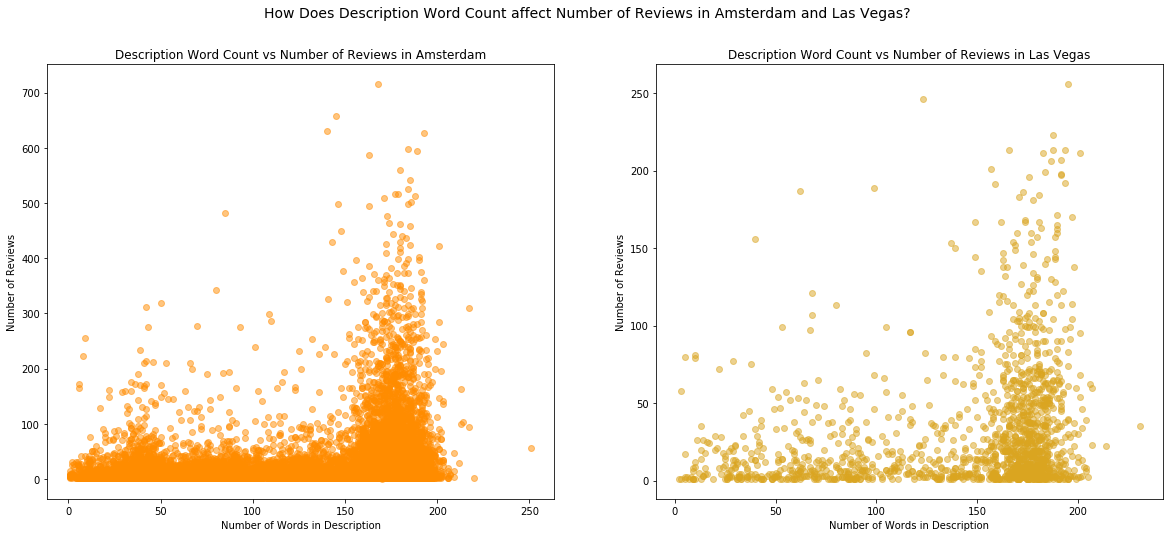

In [232]:
# Does the length of the description influence number of times place is rented
# assuming increased number of reviews means increased number of times place is rented

# get df for Las Vegas
altcity = "Las Vegas"
altcitydf, ac = getDescDF(altcity)

# plot description word count vs number of reviews for each city
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20,8))
ax1.scatter(vcitydf["desc_word_count"],vcitydf["number_of_reviews"], c=c, alpha=.5)
ax1.set_title(f"Description Word Count vs Number of Reviews in {city}")
ax1.xaxis.set_label_text('Number of Words in Description')
ax1.yaxis.set_label_text("Number of Reviews")
#ax1.xlim(0,200)

ax2.scatter(altcitydf["desc_word_count"],altcitydf["number_of_reviews"], c=ac, alpha=.5)
ax2.set_title(f"Description Word Count vs Number of Reviews in {altcity}")
ax2.xaxis.set_label_text('Number of Words in Description')
ax2.yaxis.set_label_text("Number of Reviews")

fig.suptitle(f"How Does Description Word Count affect Number of Reviews in {city} and {altcity}?", fontsize=14)

# Save the Figure
imagepath = os.path.join("saveImages","AirbnbDescWordCount.png")
plt.savefig(imagepath)

fig.show()